# Problem definition

SEC filings are long, filled with boilerplate language, and often difficult to parse through even as an experienced analyst. Let's assume that I have the following question:

> "What was the annual revenue for TSLA in 2024, and what was media sentiment after the SEC 10-K filings were released?"

For the sake of simplicity, let's assume the answer can be obtained with the following two sources:
- [TSLA 2024 10-K SEC filing](https://www.sec.gov/Archives/edgar/data/1318605/000162828025003063/tsla-20241231.htm#ie9fbbc0a99a6483f9fc1594c1ef72807_157), 347,000 tokens
- [Yahoo Finance article](https://finance.yahoo.com/news/tesla-inc-tsla-q4-2024-072241602.html), 5,000 tokens

To implement an architecture that could answer these questions, we have the following options. There are lots of LLM's we could use, but let's assume that we're using GPT 4o at commercial API usage rates. 

- GPT-4o with unfiltered context: Manually upload full context to GPT API. 
- GPT-4o with web search: Ask the question directly, and don't provide context.
- GPT-4o with keyword search: BM25 search to fetch top-N chunks that match query terms to article metadata, and send those chunks to the API.
- RAG with semantic search (GPT-4o): Search vector database for context, and  upload to GPT-4o

Using our article baseline, and assuming that each method can accurately answer the question, here are the daily cost extrapolations for a platform with the following levels of activity:

- We have a platform with 1000 concurrent users at any given moment
- These users use the platform for 10 hours per day
- Each user asks 1 question every 3 minutes, each similar to the above question (39 tokens).

| Scenario                           | Input Tokens | Output Tokens | Cost per Query (USD) | Total Daily Cost (USD) |
|------------------------------------|--------------|----------------|-----------------------|-------------------------|
| GPT-4o with unfiltered context     | 347,000      | 200            | $1.7390               | $347,800.00             |
| GPT-4o with web search             | 7,500        | 200            | $0.0415               | $8,300.00               |
| Keyword search + GPT-4o            | 3,000        | 200            | $0.0190               | $3,800.00               |
| RAG with semantic search (GPT-4o)  | 2,000        | 200            | $0.0140               | $2,800.00               |
| RAG with semantic search (GPT 3.5) | 2,000        | 200            | $0.0013               | $260              |

Our API costs would be 66% cheaper using a RAG compared to web search. If we optimize the semantic retrieval methodology for accuracy and use GPT 3.5 instead of 4o, it would be 97% cheaper. 

| Scenario                           | High Accuracy | Cost Efficient | Low Latency | Scalable | Curated Sources |
|------------------------------------|----------------|----------------|-------------|----------|---------------------|
| GPT-4o with unfiltered context     | ✅             | ❌             | ❌          | ❌       | ✅                  |
| GPT-4o with web search             | ✅             | ✅             | ✅          | ✅       | ❌                  |
| Keyword search + GPT-4o            | ❌             | ✅             | ✅          | ✅       | ✅                  |
| RAG with semantic search (GPT-4o)  | ✅             | ✅             | ✅          | ✅       | ✅                  |

# Evaluation Criteria

We'll implement all scenarios above, and evaluate them on the following criteria:

- Tier 1: Single-source QA accuracy. *How well does our engine answer questions about the 10-K filings?*
    - Evaluation data set: [financial-qa-10k](https://huggingface.co/datasets/virattt/financial-qa-10K)
    - Evaluation metrics:
        - ROUGE
        - Recall@k for chunk retrieval
        - NDCG@10
<!-- - Tier 2 (if time permits): Multi-source QA accuracy. *How well does our engine answer questions about the 10-K filings AND related media?*
    
    - Evaluation metrics:
        -  -->

# Datasets to use:

<!-- - **SEC 10-k filings** for the years 2020-2023 for AAPL, NVDA, TSLA, GOOGL. We'll scrape this data with the [EDGAR-CRAWLER](https://github.com/lefterisloukas/edgar-crawler) project. -->
- **Source SEC Filings**: the [financial-reports-sec](https://huggingface.co/datasets/JanosAudran/financial-reports-sec) dataset is already cleaned and separated into sections. I'll use this for simplicity; a real-life scenario would include implementing a pipeline to generate the features. 
- **Evaluation set**: QA answer responses based on the [financial-qa-10k](https://huggingface.co/datasets/virattt/financial-qa-10K) labeled dataset from HuggingFace. 


# EDA

## Textual analysis

First we'll get the structured 10K filings

In [1]:
#imports 
%load_ext autoreload
%autoreload 2
import sys, os
from pathlib import Path

# Add project root to sys.path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

sys.path.append("..")
import numpy as np
import pandas as pd
from pprint import pprint
from datasets import load_dataset


In [2]:
raw_data_path = project_root / "data" / 'raw'/ "df_filings_full.parquet"

# # Run the code below to download the data, it's about 20GB so not recommended unless you have time to kill
# ds = load_dataset("JanosAudran/financial-reports-sec", "large_full")
# ds = load_dataset("JanosAudran/financial-reports-sec", "large_full")
# # Save to parquet
# ds.save_to_disk(f"{raw_data_path}")
import duckdb

# Connect to in-memory database
con = duckdb.connect(database=':memory:')

query = f"""
SELECT 
  sentence, 
  docID, 
  CAST(RIGHT(docID, 4) AS INTEGER) AS fiscal_year,
  tickers[1] AS ticker,
  sentenceID
FROM read_parquet('{raw_data_path}')
WHERE tickers IS NOT NULL
  AND array_length(tickers) > 0
  AND tickers[1] IN ('AAPL', 'META', 'TSLA', 'NVDA') -- minimize corpus for computational efficiency
  AND LEN(sentence) > 20 -- filter boilerplate
"""
# Read parquet file and display first 10 rows
df = con.execute(query).df()
display(df)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,sentence,docID,fiscal_year,ticker,sentenceID
0,"ITEM 1. BUSINESS Overview We design, develop, ...",0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_0
1,We generally sell our products directly to cus...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_1
2,We also continue to grow our customer-facing i...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_2
3,"We emphasize performance, attractive styling a...",0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_3
4,We also strive to lower the cost of ownership ...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_4
...,...,...,...,...,...
98343,Exhibits See the Exhibit Index immediately fol...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_6
98344,POWER OF ATTORNEY KNOW ALL PERSONS BY THESE PR...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_7
98345,Pursuant to the requirements of the Securities...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_8
98346,† Portions of exhibit have been granted confid...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_9


The data we have above is at the sentence level. 

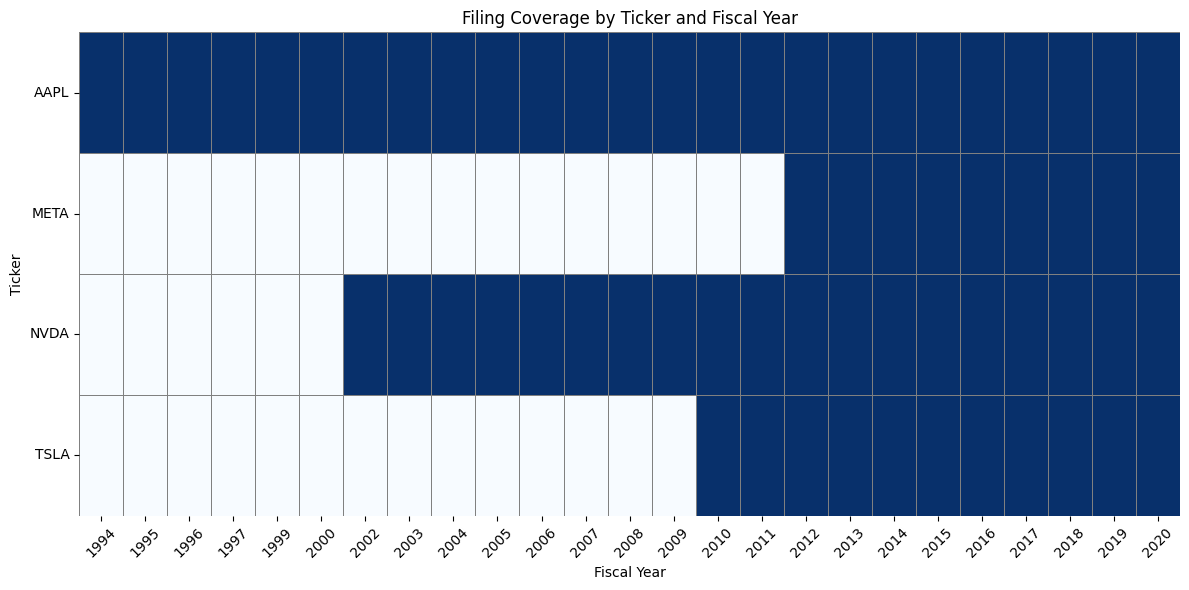

In [3]:
from eda.viz import plot_filing_coverage

plot_filing_coverage(df)

Looks like we only have all companies from 2012-2020, so we'll restrict our analysis to these years

In [4]:
df = df[df['fiscal_year'].between(2012, 2019)]

Let's do some textual EDA. First we'll see how many tokens we have per document, per sentence, and per section. Vastly different values could affect our chunking strategy. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


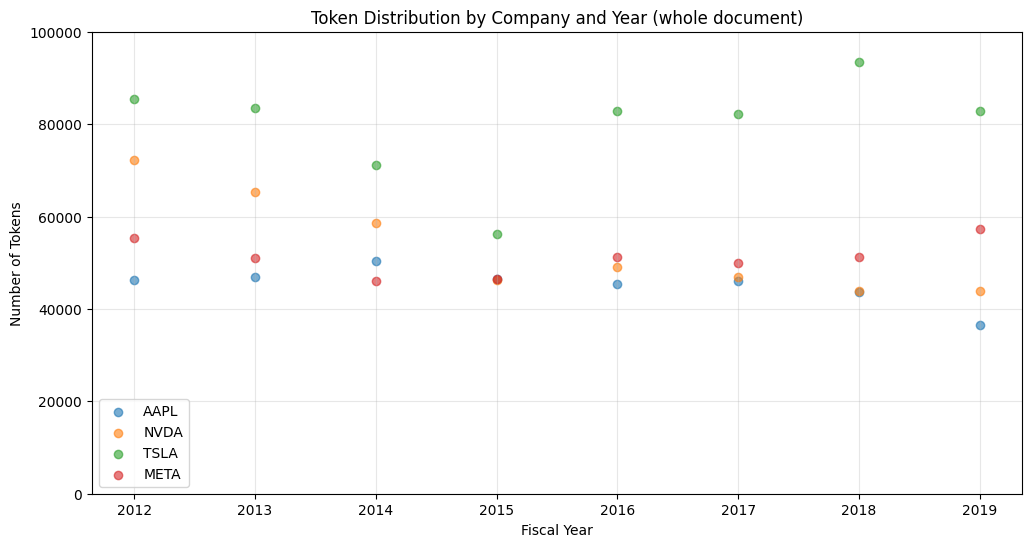

,docID,ticker,fiscal_year,full_text,num_tokens
0,0000320193_10-K_2012,AAPL,2012,Item 1. Business Company Background The Compan...,46187
1,0000320193_10-K_2013,AAPL,2013,Item 1. Business Company Background The Compan...,46989
2,0000320193_10-K_2014,AAPL,2014,Item 1. Business Company Background The Compan...,50371
3,0000320193_10-K_2015,AAPL,2015,Item 1. Business Company Background The Compan...,46542
4,0000320193_10-K_2016,AAPL,2016,Item 1. Business Company Background The Compan...,45378


In [5]:
import matplotlib.pyplot as plt
from eda.viz import count_tokens, plot_token_distribution
%load_ext autoreload
%autoreload 2

# Extract section components and create standardized section field
df['section_num'] = df['sentenceID'].str.extract(r'section_(\d+)')[0].astype(int)
df['section_letter'] = df['sentenceID'].str.extract(r'section_\d+([A-Z]?)')[0].fillna('')
df['section'] = df['section_num'].astype(str) + df['section_letter']
df['sentence_num'] = df['sentenceID'].str.extract(r'_(\d+)$')[0].astype(int)
df['sentence_token_count'] = df['sentence'].apply(count_tokens)

# Group by docID to get full document text
df_docs = (df.sort_values(['docID', 'section', 'sentence_num'])
          .groupby(['docID', 'ticker', 'fiscal_year'])
          .agg({'sentence': ' '.join})
          .reset_index()
          .rename(columns={'sentence': 'full_text'}))

# Count tokens in full text
df_docs['num_tokens'] = df_docs['full_text'].apply(count_tokens)

# Create scatter plot
plt.figure(figsize=(12, 6))
for ticker in df_docs['ticker'].unique():
    ticker_data = df_docs[df_docs['ticker'] == ticker]
    plt.scatter(ticker_data['fiscal_year'], 
                ticker_data['num_tokens'],
                label=ticker,
                alpha=0.6)

plt.title('Token Distribution by Company and Year (whole document)')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Tokens')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100_000)
plt.show()

df_docs.head()

TSLA has consistently longer documents. 

/Users/jon/GitHub/dowjones-takehome/eda/viz.py:514: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(section_tokens['section_and_description'], wrap=True)


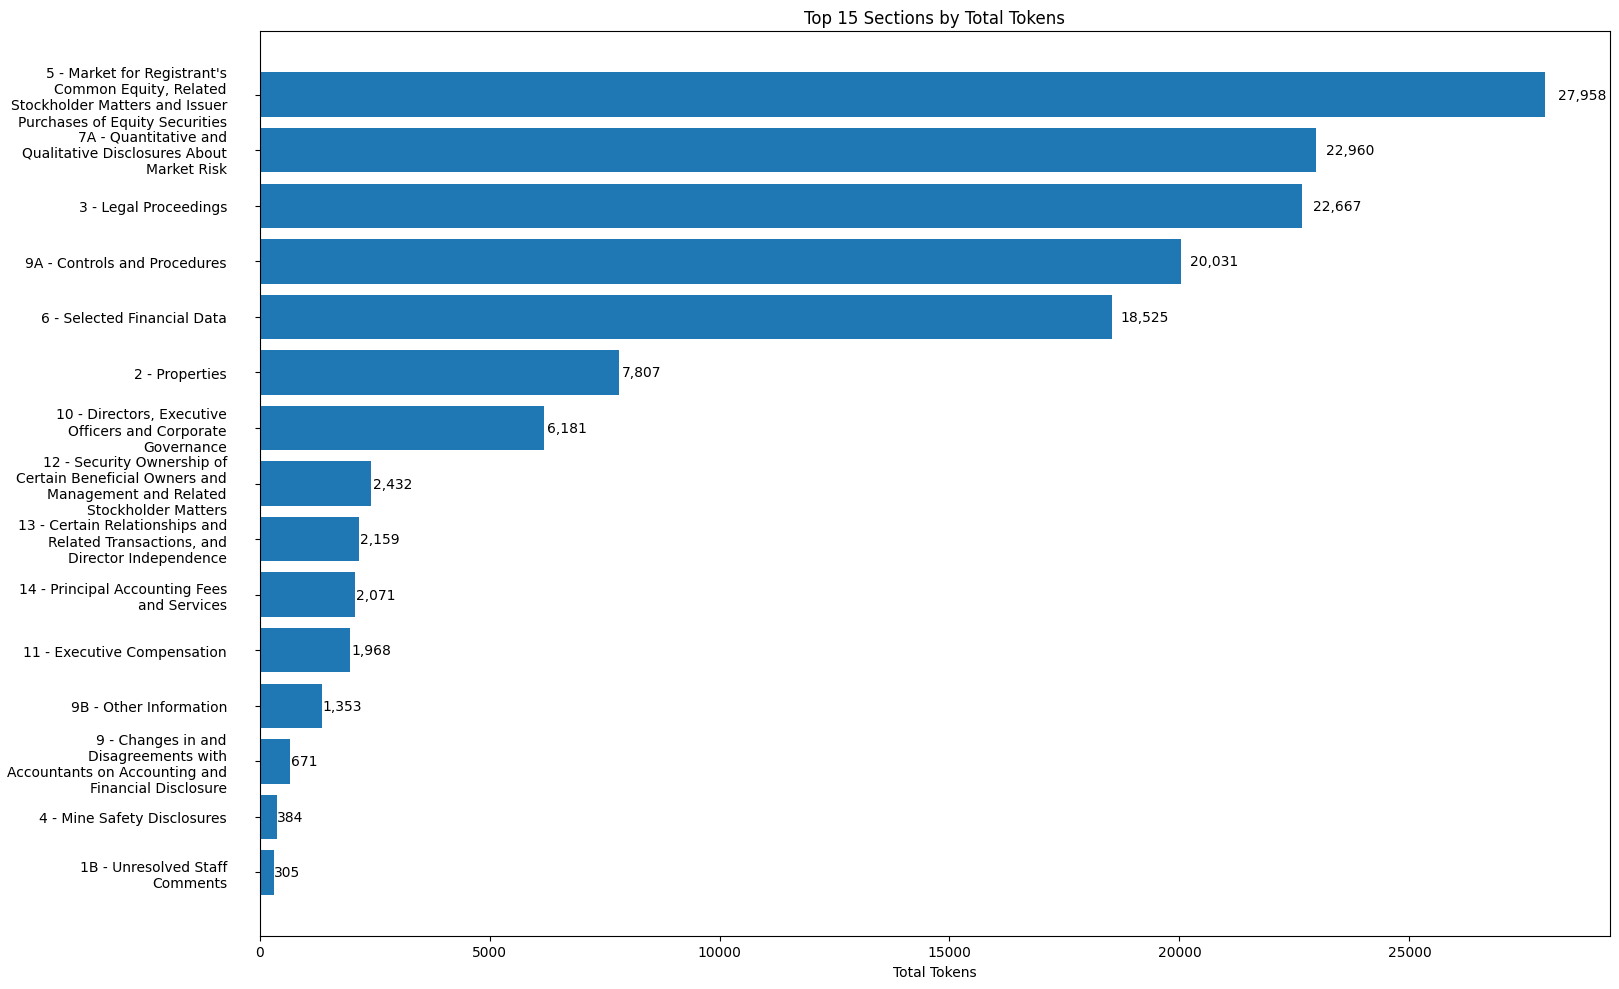

In [6]:
from eda.viz import plot_top_sections_by_tokens

# Call the function
plot_top_sections_by_tokens(df, top_n=15)

Seems there's class imbalance in the types of sections. represented. 

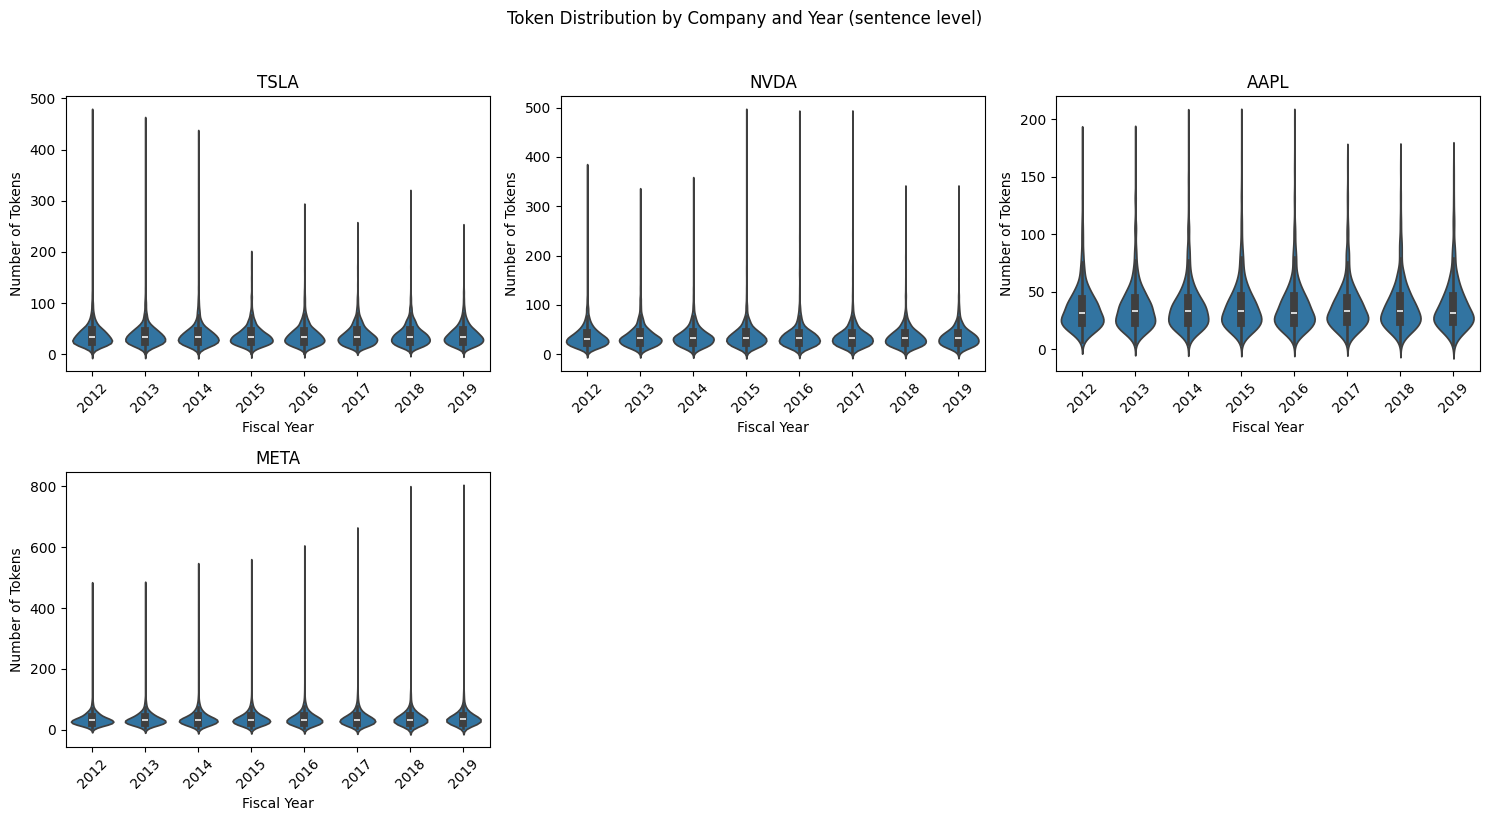

In [7]:
plot_token_distribution(df, token_col='sentence_token_count', title='Token Distribution by Company and Year (sentence level)')

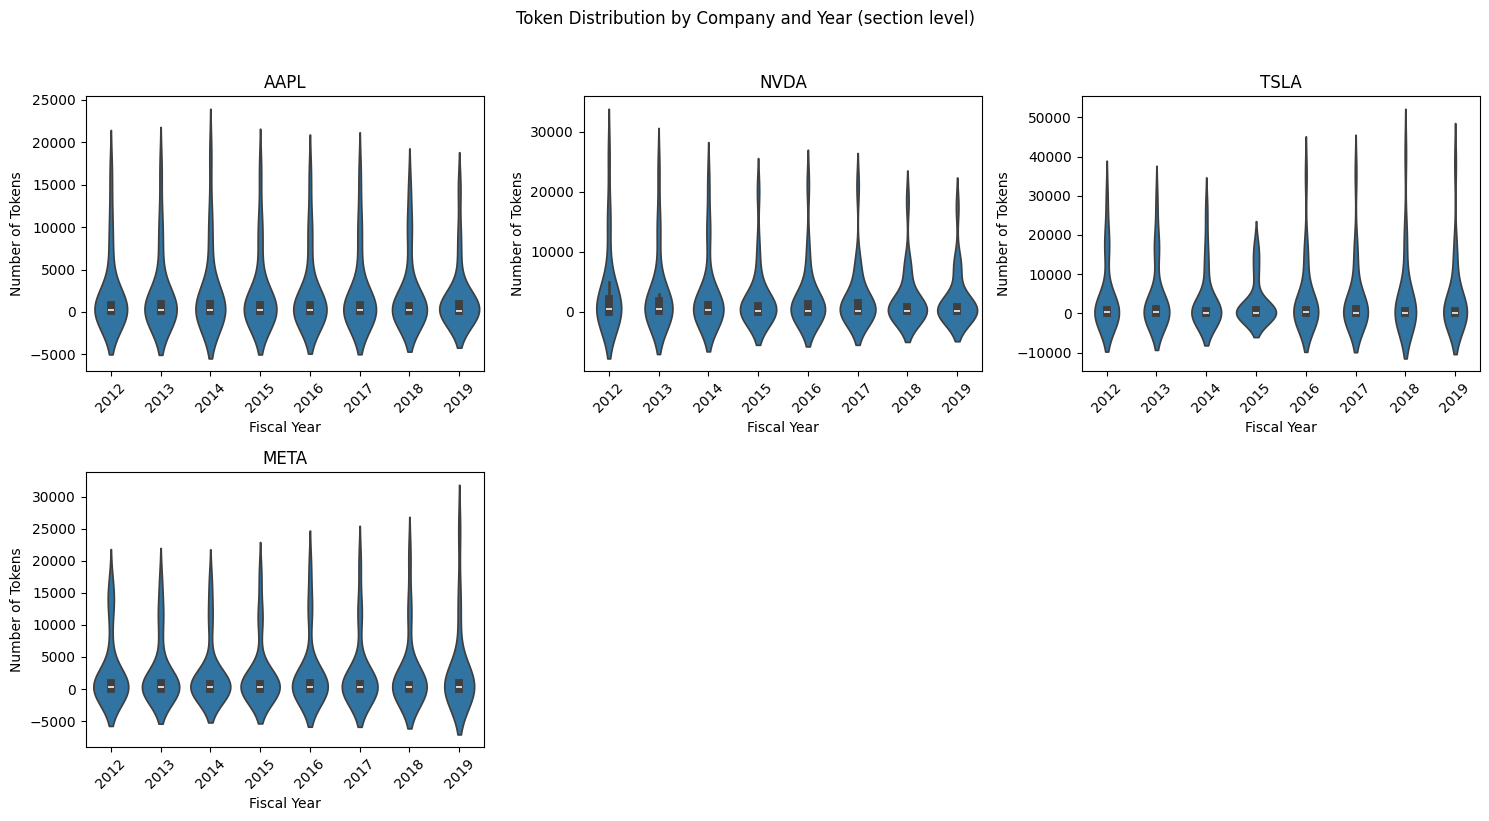

In [8]:


# Group by docID and section, sort by sentence_num, and concatenate sentences
df_docs = (df.sort_values(['docID', 'section', 'sentence_num'])
          .groupby(['docID', 'ticker', 'fiscal_year', 'section', 'section_num', 'section_letter'])
          .agg({'sentence': ' '.join})
          .reset_index()
          .rename(columns={'sentence': 'section_text'}))

df_docs['num_tokens'] = df_docs['section_text'].apply(count_tokens)
plot_token_distribution(df_docs, title='Token Distribution by Company and Year (section level)')

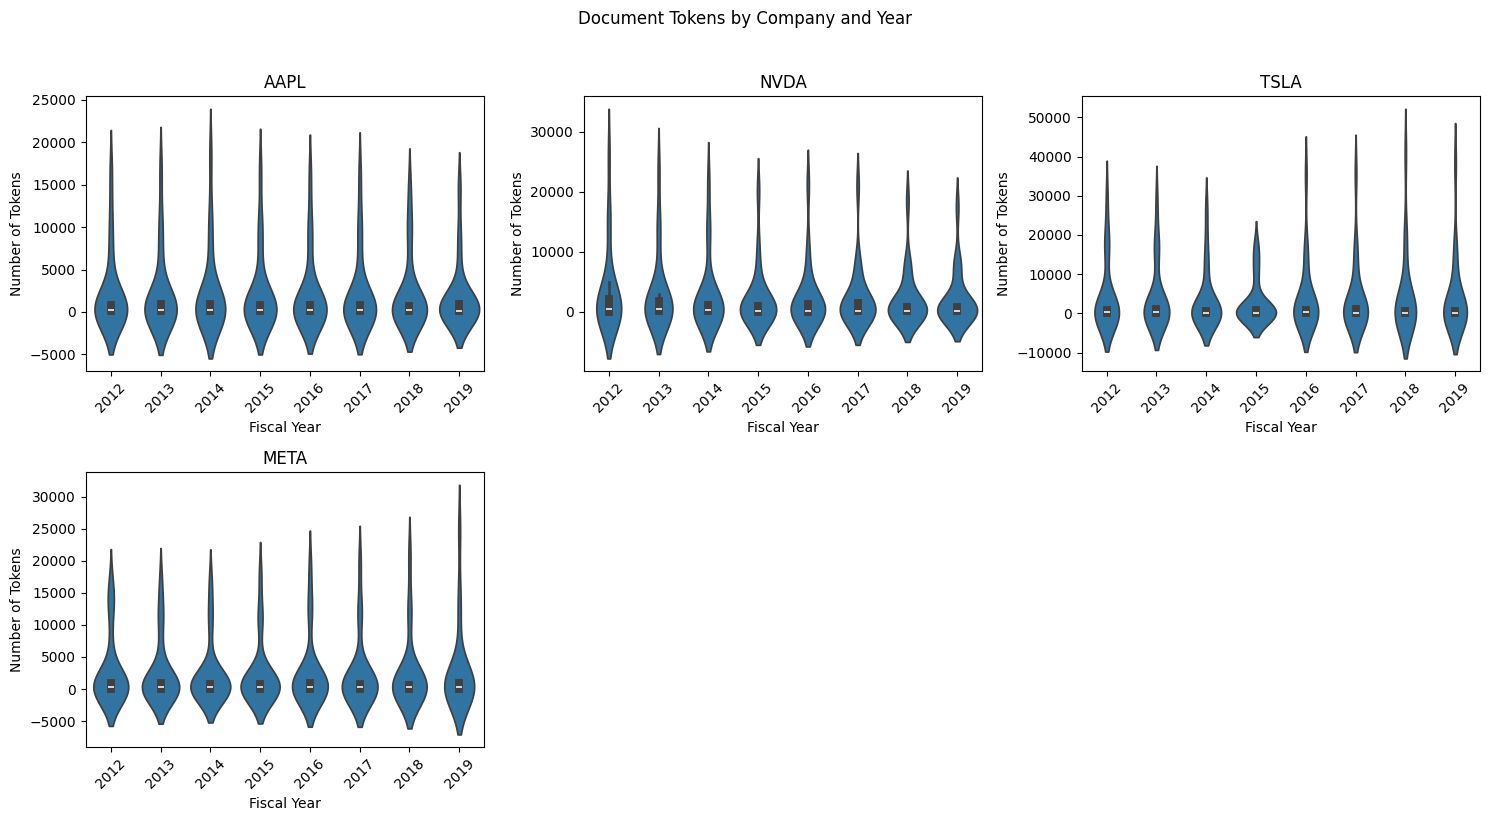

In [9]:
from eda.viz import plot_token_distribution

plot_token_distribution(
    df_docs, 
    token_col='num_tokens', 
    log_scale=False,
    title="Document Tokens by Company and Year")

OK so we have some very long sections. Most are between 0-5k tokens with a long tail up to 50k. So, we're going to have to do some pretty significant chunking. 

Documents are usually under 10k tokens. 

Sentences are usually under 100. 

- Target chunk size: 350 tokens. This is pretty standard and should get us a couple of sentences to work with, and if RAG retrieval is good then we might only need that much.
- Overlap: 50 tokens
- Hard ceiling: 800, it seems like there aren't any higher than that. 

## Chunking

Our chunking strategy will be simple:
- Set target tokens (350 for now). We're cutting off at the sentence level. 
- 50 token overlap between chunks for semantic continuity
- Set a hard ceiling of 800 tokens. If we have some *very* long sentences, and it's not possible to keep them close to 350 tokens, then we'll cut the chunk off mid-sentence and continue with the next chunk. 

We'll also include metadata in all the chunk objects, including:
- Fiscal year
- A human readable ID for debugging
- Section number
- Section description
- Section letter
- Ticker

We can use this metadata to match keywords to the query if available, and exclude chunks in the vector DB that don't include those parameters. 

In [10]:
from rag.chunkers import SmartChunker
import pickle
target_tokens = 350
hard_ceiling = 800
overlap_tokens = 50

data_path = Path(os.getcwd()).parent / 'data'
embedding_pkl_path = data_path / 'cache' / 'embeddings' /f'chunks_{target_tokens}_{hard_ceiling}_{overlap_tokens}.pkl'

if embedding_pkl_path.exists():
    with open(embedding_pkl_path, 'rb') as f:
        chunks = pickle.load(f)
        print(f"✅ Loaded {len(chunks)} chunks from {embedding_pkl_path}")
else:
    chunker = SmartChunker(target_tokens=target_tokens, hard_ceiling=hard_ceiling, overlap_tokens=overlap_tokens)
    chunks = chunker.run(df)
    with open(embedding_pkl_path, 'wb') as f:
        pickle.dump(chunks, f)
    print(f"✅ Saved {len(chunks)} chunks to {embedding_pkl_path}")

print("Example chunk:")
pprint(chunks[0])


✅ Loaded 7837 chunks from /Users/jon/GitHub/dowjones-takehome/data/cache/embeddings/chunks_350_800_50.pkl
Example chunk:
Chunk(id='baf67bd9-9742-5521-80f2-f44d086c4c6c',
      text='Item 1. Business Company Background The Company designs, '
           'manufactures and markets mobile communication and media devices, '
           'personal computers, and portable digital music players, and sells '
           'a variety of related software, services, peripherals, networking '
           'solutions, and third-party digital content and applications. The '
           'Company’s products and services include iPhone®, iPad®, Mac®, '
           'iPod®, Apple TV®, a portfolio of consumer and professional '
           'software applications, the iOS and OS X® operating systems, '
           'iCloud®, and a variety of accessory, service and support '
           'offerings. The Company also sells and delivers digital content and '
           'applications through the iTunes Store®, App StoreSM, iB

Key takeaways:
- 10K sections seem to be clustered together, showing that the embedding model is capturing the semantic similarities between them regardless of the company
- No clear difference in semantics throughout time
- TSLA 10K filings seem to be clustered together distinct from other companies, but NVDA META and AAPL have more overlap. This clustering isn't strong, though. 
- There are some outliers, which often seem to come from less frequently seen sections, or supplementary data (miscellaneous facts that didn't fit elsewhere in the document). This all makes sense. 

Overall the embedding model seems to be capturing semantic similarity the way we should. No clear evidence to change models from OpenAI just yet. 

## Embedding generation and analysis

For simplicity, we'll get Open AI's embeddings. There are better transformer models for this domain, and usually I would prefer to use a fine-tuned text embedding model that's been trained mostly on a corpus of financial texts, but many don't have API's. To avoid GPU cloud cost, I'll use OpenAI embeddings instead of alternatives, best option being `jina-embeddings-v3` which is trained for long form QA retrieval tasks. 

In production I assume we'll use our own embedding model hosted on our own infra, so I won't calculate this cost into the final savings. 

In [11]:
# add embeddings to chunks using openai
import openai
import torch
from tqdm import tqdm

from rag.config import VectorStoreConfig

if embedding_pkl_path.exists() and chunks[0].embedding is not None:
    with open(embedding_pkl_path, 'rb') as f:
        chunks = pickle.load(f)
        print(f"✅ Loaded {len(chunks)} chunks from {embedding_pkl_path}")
else:
    print("No embeddings found, generating new embeddings")    
    # Initialize OpenAI client
    client = openai.OpenAI()
    model = VectorStoreConfig.model
    dim = VectorStoreConfig.dim

    # Extract all text from chunks
    texts = [chunk.text for chunk in chunks]

    # Get embeddings in batches to avoid rate limits
    batch_size = 100
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Getting embeddings"):
        batch_texts = texts[i:i + batch_size]
        
        response = client.embeddings.create(
            model=model,
            input=batch_texts
        )
        
        # Extract embeddings and convert to torch tensors, ensuring 1536 dimensions
        batch_embeddings = []
        for emb in response.data:
            embedding_tensor = torch.tensor(emb.embedding, dtype=torch.float32)
            # Pad to 1536 dimensions if needed
            if embedding_tensor.shape[0] < dim:
                padding = torch.zeros(dim - embedding_tensor.shape[0], dtype=torch.float32)
                embedding_tensor = torch.cat([embedding_tensor, padding])
            batch_embeddings.append(embedding_tensor)
        
        embeddings.extend(batch_embeddings)

    # Assign embeddings to chunks
    for chunk, embedding in tqdm(zip(chunks, embeddings), desc="Assigning embeddings to chunks", total=len(chunks)):
        chunk.embedding = embedding

    with open(embedding_pkl_path, 'wb') as f:
        pickle.dump(chunks, f)

    print(f"✅ Added embeddings to {len(chunks)} chunks")

✅ Loaded 7837 chunks from /Users/jon/GitHub/dowjones-takehome/data/cache/embeddings/chunks_350_800_50.pkl


In [12]:
import pandas as pd
import plotly.express as px
from umap import UMAP



df_embeddings = pd.DataFrame(
    {
    'embedding': [chunk.embedding for chunk in chunks],
    'company': [chunk.metadata['ticker'] for chunk in chunks],
    'year': [chunk.metadata['fiscal_year'] for chunk in chunks],
    'section_num': [int(str(chunk.metadata['section_num'])) for chunk in chunks],
    'section': [chunk.metadata['section'] + chunk.metadata['section_letter'] for chunk in chunks],
    'section_desc': [chunk.metadata['section_desc'] for chunk in chunks],
    }
)

# Step 2: Reduce to 2D
reducer = UMAP()
df_embeddings['x'], df_embeddings['y'] = zip(*reducer.fit_transform(list(df_embeddings['embedding'])))

# Step 3: Visualize
fig1 = px.scatter(df_embeddings, x='x', y='y', color='year', hover_data=['company'], title='Embeddings by Year')
fig1.update_layout(
    # width=1500,
    height=750,
)
fig1.show()

fig2 = px.scatter(df_embeddings, x='x', y='y', color='company', hover_data=['section'], title='Embeddings by Company')
fig2.update_layout(
    # width=1500,
    height=750,
)
fig2.show()

fig3 = px.scatter(df_embeddings, x='x', y='y', color='section_desc', hover_data=['company'], title='Embeddings by Document Section')
fig3.update_layout(
    # width=1500,
    height=750,
    legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5)
)
fig3.show()


/Users/jon/GitHub/dowjones-takehome/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Key takeaways:
- 10K sections seem to be clustered together, showing that the embedding model is capturing the semantic similarities between them regardless of the company
- No clear difference in semantics throughout time
- TSLA 10K filings seem to be clustered together distinct from other companies, but NVDA META and AAPL have more overlap. This clustering isn't strong, though. 
- There are some outliers, which often seem to come from less frequently seen sections, or supplementary data (miscellaneous facts that didn't fit elsewhere in the document). This all makes sense. 

Overall the embedding model seems to be capturing semantic similarity the way we should. No clear evidence to change models from OpenAI just yet. 

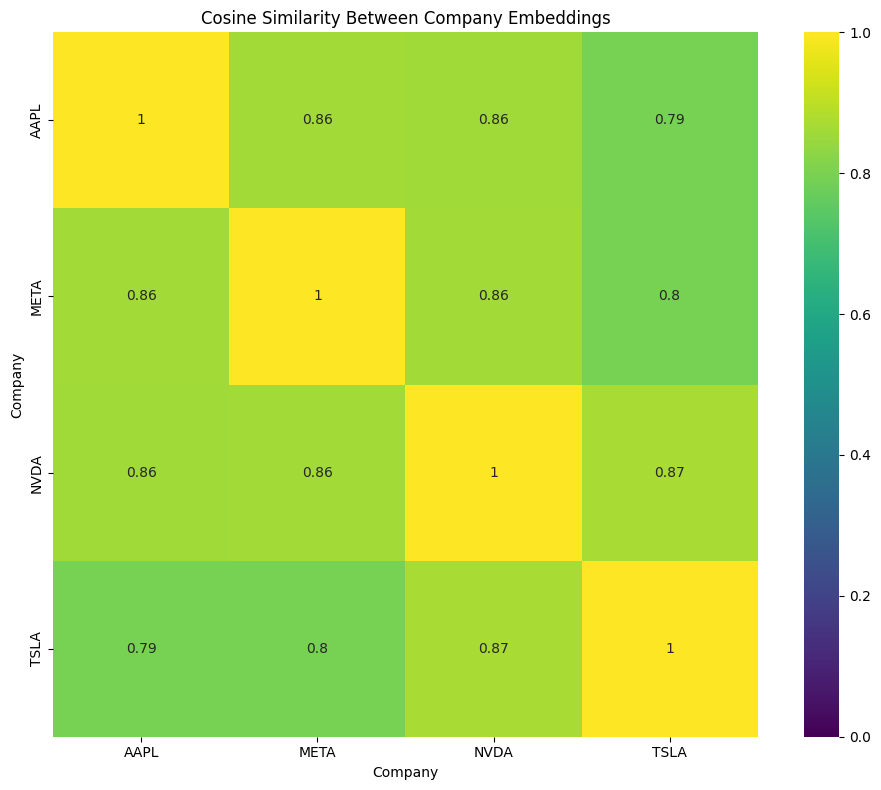

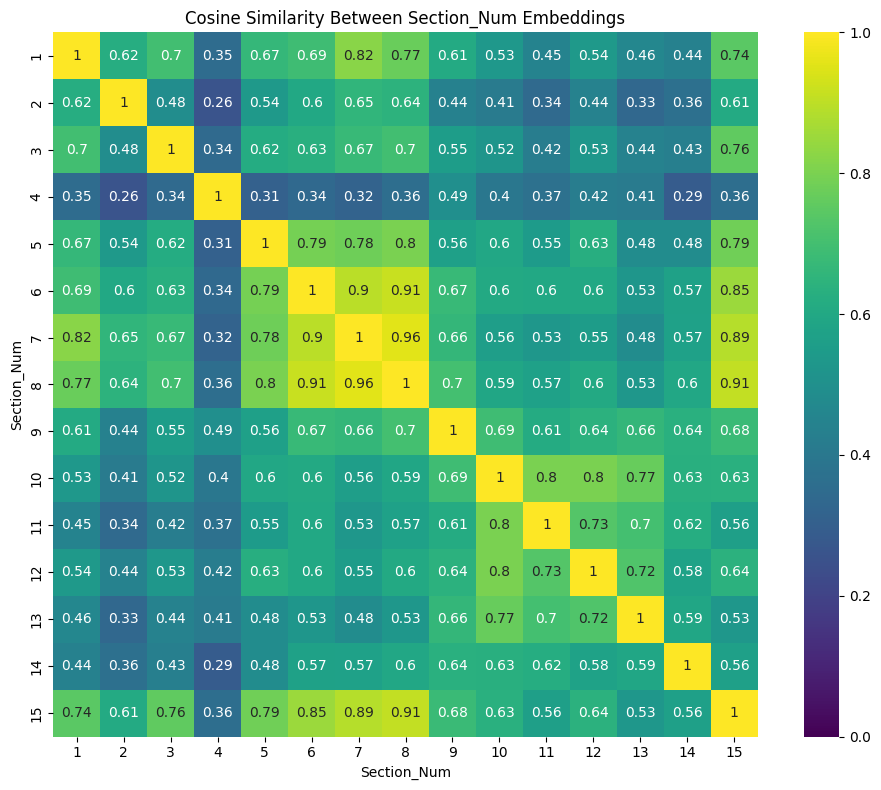

In [13]:
from eda.viz import plot_embedding_similarity
    
# Example usage:
plot_embedding_similarity(df_embeddings, dimension='company')
plot_embedding_similarity(df_embeddings, dimension='section_num')


Sections 6-8 have high similarity between each other. We could probably set some logic that if a question is likely about something in section 6, we'll weight sections 7 and 8 higher in the retrieval process. 

# Labeled Dataset Creation

We need to have ground truth to compare our RAG predictions to in order to evaluate their recall/precision. I will use `LangChain`'s OpenAI wrapper functionality to create QA pairs from chunks. There is some skepticism from the NLP community about the validity of LLM-generated training data or evaluation data, but due to resource/time limitations I'll assume that the LLM generated questions are valid. Considering the short context of the chunks given to the LLM, and the types of questions we're aiming for ("How much operating revenue did Tesla make in 2015?"), the risk that the metrics we obtain are entirely unreliable is low. 

In a real-world scenario, I would prefer to have a professionally labeled dataset with questions similar to what analysts/consultants may ask, with validated answers, along with daily quality checks of some sort, perhaps a rolling z-score deviation of the cosine similarity of certain clusters of documents, and an automated evaluation/tuning loop, but that's outside of the scope of this project. 

The following prompt is used:
```
You are a financial analyst assistant. Your job is to generate high-quality question-answer pairs based on SEC filing text.
INSTRUCTIONS:
1. Generate 2 specific, answerable questions based ONLY on the provided text.
2. Each question must explicitly include the company name and fiscal year.
3. Provide accurate, concise answers based solely on the text content.
4. Return your response as valid JSON in this exact format: {"qa_pairs": [{"question": "...", "answer": "..."}, ...]}
```

In [24]:
%load_ext autoreload
%autoreload 2

from evaluation.generate_qa_dataset import generate_qa_pairs, prepare_chunks_for_qa_generation
import random

# Take first 5 chunks and prepare them for QA generation
test_group = random.sample(chunks, 2)
prepared_chunks = prepare_chunks_for_qa_generation(test_group)
# Now generate QA pairs
example_qa_pairs = generate_qa_pairs(prepared_chunks, debug_mode=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


🤖 Generating QA pairs (via LangChain):   0%|          | 0/2 [00:00<?, ?chunk/s]

{'answer': "A decline in the company's stock price could significantly "
           'increase the effective tax rate.',
 'chunk_id': '3a30389b-8638-5fe6-9741-05d2b703d02c',
 'human_readable_id': 'META_2017_1A_43',
 'question': 'What could significantly increase the effective tax rate for the '
             'company in the fiscal year?',
 'section': '1A',
 'section_letter': 'A',
 'section_num': '1',
 'source_text': 'These tax effects are dependent on our stock price, which we '
                'do not control, and a decline in our stock price could '
                'significantly increase our effective tax rate and adversely '
                'affect our financial results. Our business is subject to '
                'complex and evolving U.S. and foreign laws and regulations '
                'regarding privacy, data protection, content, competition, '
                'consumer protection, and other matters. Many of these laws '
                'and regulations are subject to change a

Notice that some of the questions don't specifically mention the company name, even when prompted. I played around with a lot of prompts to get it to generate the company name consistently, but to no avail. This could be the target for fine tuning at a later stage. 

My short term solution is to inject the information into the beginning of the question like so:

```python
prompt = f"""
Company name: {ticker}\n
Fiscal year: {fiscal_year}
{generated_question}
"""
```

## Parameter optimization

First we should optimize the number of tokens per chunk split. I ran 50 questions on four different splits to optimize for recall, MRR, and Rouge. 

In [27]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))
import pandas as pd

from chunking_comparison import compare_chunking_configs

configs = [
    {"target_tokens": 150, "overlap_tokens": 25, "name": "Small_150_25"},
    {"target_tokens": 300, "overlap_tokens": 50, "name": "Medium_300_50"},
    {"target_tokens": 500, "overlap_tokens": 100, "name": "Large_500_100"},
    {"target_tokens": 750, "overlap_tokens": 150, "name": "XLarge_750_150"}
]

df_results = compare_chunking_configs(num_questions=50, configs=configs)
df_results.to_csv(data_path / 'chunking_comparison_results.csv')
# df_results = pd.read_csv(data_path / 'chunking_comparison_results.csv')
# df_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jon/GitHub/dowjones-takehome/data/chunking_comparison_results.csv'

Takeaways:
 - Recall at 1 is highest with the extra large model. This makes sense, as the more context we feed the model, the more likely the correct information is in the chunk. 
 - MRR (Mean Reciprocal Rank) is also highest in the extra large model. This also makes sense, as more context per chunk leads to a higher probability that the correct information is in the chunk. 
- Rouge-1 is highest for smaller models. When we have smaller chunks, we have a lower probability of getting the most accurate chunk, but when we do the unigram overlap is high. 

This tells me that we should keep a higher chunk size. We have could more overlap AND more chunks, but for the sake of this exercise I'm going to assume that 750/150 is the optimal combination for now. 

## Vector store

Now we create our vector DB. I'm choosing to use Qdrant because unlike FAISS it can handle metadata, which we have, and it's more widely used in production environments. 

In [25]:
from rag.vector_db import VectorStore

# initialize
vs = VectorStore()
vs.init_collection()

# first upload: 10k SEC filings
vs.upsert(
    texts=[c.text for c in chunks],
    metas=[c.metadata for c in chunks],
    ids=list(range(len(chunks))),
)

# query
results = vs.search("What risks did Meta mention in 2019?", top_k=10)


ModuleNotFoundError: No module named 'rag.vector_db'

# Scenarios to compare

We've generated a labeled dataset with LangChain based on a stratified selection of chunks from our corpus. This will be our source of truth by which we'll compare our five different models:

- Baseline: `gpt-4o-mini` with no extra context
- Web search: `gpt-40-mini-search-preview` without extra context
- Full context: `gpt-4o-mini` with the entire relevant SEC document as context
- Vanilla RAG: Chunked corpus uploaded into a Qdrant vector database with metadata. Top k=10 chunks will be retrieved. 
- ReRanked RAG: Same as Vanilla RAG but with the `BAAI/bge-reranker-base` reranking model applied. 

## Baseline

We expect this to perform poorly, as we're giving it no context and only relying on the model's training data for very specific questions. Here's an example of what we can expect from it:

In [11]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(str(Path(os.getcwd()).parent))

from evaluation.scenarios import run_baseline_scenario
from rag.config import DEFAULT_OPENAI_KEY
from openai import OpenAI

openai_client = OpenAI(api_key=DEFAULT_OPENAI_KEY)

question = "What risks does Apple Inc. face regarding its inventory and asset management in the fiscal year 2017?"
qa_item = {
    "question": question,
    "ticker": "AAPL",
    "year": 2017
}

run_baseline_scenario(openai_client, qa_item)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('In fiscal year 2017, Apple Inc. faced several risks related to inventory and asset management, including fluctuations in demand for its products, which could lead to excess inventory or stockouts. Additionally, the rapid pace of technological change in the consumer electronics industry posed a risk of obsolescence for its',
 {'prompt_tokens': 234, 'completion_tokens': 60, 'total_tokens': 294})

## Baseline with web search

OpenAI recently released a version of the API with access to web searches. This could be beneficial for publicly accessible data, but for private data or data which could potentially have a lot of biased web results, it might not be suitable. 

In [12]:
from evaluation.scenarios import run_web_search_scenario


openai_client = OpenAI(api_key=DEFAULT_OPENAI_KEY)

qa_item = {
    "question": question,
    "ticker": "AAPL",
    "year": 2017
}

run_web_search_scenario(openai_client, qa_item)

("In its fiscal year 2017 Form 10-K, Apple Inc. identified several risks related to inventory and asset management:\n\n- **Obsolescence and Demand Fluctuations**: Apple records write-downs for product and component inventories that become obsolete or exceed anticipated demand. ([sec.gov](https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/a10-k20179302017.htm?utm_source=openai))\n\n- **Supply Chain Concentration**: The company relies on a small number of outsourcing partners, often in single locations, for manufacturing. Disruptions with these partners could adversely affect Apple's operations. ([sec.gov](https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/a10-k20179302017.htm?utm_source=openai))\n\n- **Component Sourcing Risks**: Many components are sourced from single or limited suppliers, exposing Apple to supply shortages and price increases. ([sec.gov](https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/a10-k20179302017.htm?utm_source=open

## Vanilla RAG


## Re-Ranking

In addition to using a vanilla RAG, which only compares the cosine similarity between the embedded user query and the corpus embeddings, re-ranking adds another layer. 

Cross embedding adds a BERT  transformer layer to encode the interaction between the query and the doc. It can classify words as classifiers, separators, which gives it more power to infer semantic similarity rather than weighing all token embeddings equally. 

In our use case, we'll also add a RAG with re-ranking. In a production environment I'd prefer to use a larger or fine-tuned model, but for our use case we're going to use the `BAAI/bge-reranker-base` for local inference. 

# Preprocessing

## Filings

# Chunking

In [139]:
from src.filing_exploder import FilingExploder, FilingPreprocessor, Chunker

df_items = FilingExploder().explode(df_filings)

# Create two versions - one with stopwords, one without
cleaner = FilingPreprocessor(stopwords=None, spacy_model="en_core_web_sm")
# cleaner_no_stopwords = FilingPreprocessor(stopwords=fin_stopwords, spacy_model="en_core_web_sm")

df_items["clean_text_with_stopwords"] = df_items["text"].map(cleaner.clean)
# df_items["clean_text_no_stopwords"] = df_items["text"].map(cleaner_no_stopwords.clean)

chunker = Chunker()
chunks = []
# chunks_no_stopwords = []

for _, row in df_items.iterrows():
    meta = {"ticker": row["ticker"], "fiscal_year": row["fiscal_year"], "item": row["item"]}
    chunks.extend(chunker.chunk(row["clean_text_with_stopwords"], meta))
    # chunks_no_stopwords.extend(chunker.chunk(row["clean_text_no_stopwords"], meta))

In [140]:
chunks[0]

Chunk(id='META_2020_1_0', text='item business overview item 1.business overview mission people power build community bring world close build useful engaging product enable people connect share friend family mobile device personal computer virtual reality headset home device help people discover learn go world enable people share opinion idea photo video activity audience range close family member friend public large stay connected access product include facebook facebook enable people connect share discover communicate mobile device personal computer number different way engage people facebook build community include facebook news feed story group shop marketplace news watch instagram instagram bring people close people thing love place people express photo video private messaging connect shop favorite business creator instagram feed story reel IGTV live shop message messenger messenger simple powerful message application people connect friend family group business platform device chat